解不到对应的z,power spectrum暂时放弃

$dtauda=\dfrac{d\tau}{da}=\dfrac{dt}{ada}=\dfrac{1}{a\dot{a}}$

In [13]:
# solution.py
import numpy as np
import scipy

# Global fundamental constants
import astropy.units as u

distance_mpc = 1 * u.Mpc
distance_km = distance_mpc.to(u.km)
time_gyr = 1 * u.Gyr
time_s = time_gyr.to(u.s)
# Unit conversion (1/H0 to Gyr)
transfer = (distance_km / time_s).value

# Reconstruct z as a vector function z = [dz0, dz1, dz2]
def function(t, z, kC1, O10, H0):
    # z[0] = z(t), z[1] = z'(t), z[2] = z''(t)
    dz1 = z[1]
    # Reduce the use of parentheses, separate into numerator and denominator
    numerator = (
        H0**4 * kC1 * O10**2 * (z[0]**4 + 1) +
        3 * H0**4 * O10**2 * z[0]**2 * (2 * kC1 - 3 * z[1]) +
        H0**4 * O10**2 * z[0]**3 * (4 * kC1 - 3 * z[1]) -
        3 * H0**4 * O10**2 * z[1] +
        5 * H0**2 * O10 * z[1]**3 -
        kC1 * z[1]**4 +
        H0**2 * O10 * z[0] * (4 * H0**2 * kC1 * O10 - 9 * H0**2 * O10 * z[1] + 5 * z[1]**3)
    )
    denominator = 2 * H0**2 * O10 * (1 + z[0])**2 * z[1]
    dz2 = numerator / denominator
    return [dz1, dz2]

# Solve the original equation for z(t) and z'(t)
def solution(log_kC1, O20, H0):
    # Unit conversion
    kC1 = 10**log_kC1 * transfer
    O10 = 1 - O20
    t0 = 1 / H0
    # Solution interval
    tspan = (t0, 0)
    tn = np.linspace(t0, 0, 100000)
    # Start from t0
    zt0 = [0, -H0]

    # Initial value given at t0
    z = scipy.integrate.solve_ivp(function, t_span=tspan, y0=zt0, t_eval=tn, method='RK45',
                                args=(kC1, O10, H0))
    # z.y[0,:] = z(t), z.y[1,:] = z'(t)
    return z

In [14]:
# from julia import Main
# Main.include("../solution.jl")

In [15]:
z = solution(-3, 0.3, 70)
# z_jl = Main.result(-6.0, 0.3, 70.0)
print(len(z.t))
print(z.y[0][-1])

93653
39.705077215969624


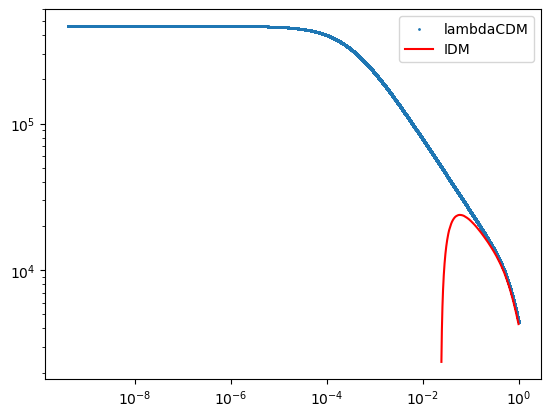

In [16]:
import matplotlib.pyplot as plt
from astropy.constants import c
c_const = c.to('km/s').value

a = 1 / (1 + z.y[0,:])
dota = -z.y[1,:] * a ** 2
dtauda = 1 / (a * dota) * c_const

# a_jl = 1 / (1 + z_jl[0])
# dota_jl = -z_jl[1] * a_jl ** 2
# dtauda_jl = 1 / (a_jl * dota_jl) * c_const

data = np.loadtxt('dtauda.txt')
a_list = data[:, 0]
dtauda_list = data[:, 1]

plt.scatter(a_list, dtauda_list, label='lambdaCDM', s=1)
plt.plot(a, dtauda, label='IDM', color='red')
# plt.plot(a_jl, dtauda_jl, label='Julia', color='blue')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

传参  
model.f90
```fortran
        real(dl), allocatable :: a_list(:)
        real(dl), allocatable :: dtauda_list(:)
```  
model.py
```python
        ("a_list", AllocatableArrayDouble),
        ("dtauda_list", AllocatableArrayDouble),
```

```fortran
function dtauda(this,a)
    use results
    implicit none
    class(CAMBdata) :: this
    real(dl), intent(in) :: a
    real(dl) :: dtauda
    real(dl), allocatable :: a_list(:), dtauda_list(:)
    integer :: low, high, mid, i, n

    a_list = this%CP%a_list
    dtauda_list = this%CP%dtauda_list

    low = 1
    high = size(a_list)
    if (a <= a_list(high)) then
        dtauda = dtauda_list(high)
    else
        do i=1,18 ! n about 100000
            mid = (low + high)/2
            if (a == a_list(mid)) then
                dtauda = dtauda_list(mid)
                exit
            else if (a > a_list(mid)) then
                high = mid - 1
            else
                low = mid + 1
            end if
        end do
        dtauda = dtauda_list(mid) + (dtauda_list(mid-1)-dtauda_list(mid))*(a-a_list(mid))/(a_list(mid-1)-a_list(mid))
    end if
end function dtauda
```